In [1]:
import os
import pandas as pd
import seaborn as sns
import rasterio as rio
from osgeo import gdal
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import mapping

# Functions

In [2]:
def read_raster_arr_object(raster_file, rasterio_obj=False, band=1, get_file=True, change_dtype=True):
    """
    Get raster array and raster file.

    :param raster_file: Input raster filepath.
    :param rasterio_obj: Set True if raster_file is a rasterio object.
    :param band: Selected band to read. Default set to 1.
    :param get_file: Set to False if raster file is not required.
    :param change_dtype: Set to True if want to change raster data type to float. Default set to True.

    :return: Raster numpy array and rasterio object file (get_file=True, rasterio_obj=False).
    """
    if not rasterio_obj:
        raster_file = rio.open(raster_file)
    else:
        get_file = False
    raster_arr = raster_file.read(band)
    if change_dtype:
        raster_arr = raster_arr.astype(np.float32)
        if raster_file.nodata:
            raster_arr[np.isclose(raster_arr, raster_file.nodata)] = np.nan
    if get_file:
        return raster_arr, raster_file
    else:
        return raster_arr


def write_array_to_raster(raster_arr, raster_file, transform, output_path, dtype=None,
                          ref_file=None, nodata=-9999):
    """
    Write raster array to Geotiff format.

    :param raster_arr: Raster array data to be written.
    :param raster_file: Original rasterio raster file containing geo-coordinates.
    :param transform: Affine transformation matrix.
    :param output_path: Output filepath.
    :param dtype: Output raster data type. Default set to None.
    :param ref_file: Write output raster considering parameters from reference raster file.
    :param nodata: no_data_value set as -9999.

    :return: Output filepath.
    """
    if dtype is None:
        dtype = raster_arr.dtype

    if ref_file:
        raster_file = rio.open(ref_file)
        transform = raster_file.transform

    with rio.open(
            output_path,
            'w',
            driver='GTiff',
            height=raster_arr.shape[0],
            width=raster_arr.shape[1],
            dtype=dtype,
            count=raster_file.count,
            crs=raster_file.crs,
            transform=transform,
            nodata=nodata
    ) as dst:
        dst.write(raster_arr, raster_file.count)

    return output_path

def mask_raster_by_extent(input_raster, ref_file, output_dir, raster_name, invert=False, crop=True,
                          nodata=-9999):
    """
    Crop/mask a raster with a given shapefile/raster's extent. Only use to crop to extent.
    Cannot perform cropping to exact shapefile.

    :param input_raster: Filepath of input raster.
    :param ref_file: Filepath of raster or shape file to crop input_raster.
    :param output_dir: Filepath of output directory.
    :param raster_name: Masked raster name.
    :param invert: If False (default) pixels outside shapes will be masked.
                   If True, pixels inside shape will be masked.
    :param crop: Whether to crop the raster to the extent of the shapes. Change to False if invert=True is used.

    :return: Filepath of cropped raster.
    """
    # opening input raster
    raster_arr, input_file = read_raster_arr_object(input_raster, change_dtype=False)

    if '.shp' in ref_file:
        ref_extent = gpd.read_file(ref_file)
    else:
        ref_raster = rio.open(ref_file)
        minx, miny, maxx, maxy = ref_raster.bounds
        ref_extent = gpd.GeoDataFrame({'geometry': box(minx, miny, maxx, maxy)}, index=[0],
                                      crs=ref_raster.crs.to_string())

    ref_extent = ref_extent.to_crs(crs=input_file.crs.data)
    geoms = ref_extent['geometry'].values  # list of shapely geometries
    geoms = [mapping(geoms[0])]   # geometry in json format

    # masking
    masked_arr, mask_transform = mask(dataset=input_file, shapes=geoms, filled=True, crop=crop, invert=invert,
                                          all_touched=False)
    masked_arr = masked_arr.squeeze()  # Remove axes of length 1 from the array

    # naming output file
    makedirs([output_dir])
    output_raster = os.path.join(output_dir, raster_name)

    # saving output raster
    write_array_to_raster(raster_arr=masked_arr, raster_file=input_file, transform=mask_transform,
                          output_path=output_raster, nodata=nodata)

    return masked_arr, output_raster

def makedirs(directory_list):
    """
    Make directory (if not exists) from a list of directory.

    :param directory_list: A list of directories to create.

    :return: None.
    """
    for directory in directory_list:
        if not os.path.exists(directory):
            os.makedirs(directory)

----------------

## Masking monthly training and prediction raster with training zone shapefile and creating dataframes

In [3]:
cv_training_zone = '../../Data_main/Raster_data/Rainfed_cropET_filtered_training/shapes/shape_1.shp'  # central valley, CA
sr_training_zone = '../../Data_main/Raster_data/Rainfed_cropET_filtered_training/shapes/shape_18.shp'  # snake river basin, ID
gmd_training_zone = '../../Data_main/Raster_data/Rainfed_cropET_filtered_training/shapes/shape_20.shp'  # HPA, KS
ne_training_zone = '../../Data_main/Raster_data/Rainfed_cropET_filtered_training/shapes/shape_14.shp'  # HPA, NE

training_raster = '../../Data_main/Raster_data/Rainfed_cropET_filtered_training/final_filtered_cropET_for_training/CropET_for_training_2016_6.tif'
prediction_raster = '../../Data_main/Raster_data/Effective_precip_prediction_WestUS/v5_monthly/effective_precip_2016_6.tif'

In [4]:
data_output_dir = '../../Eff_Precip_Model_Run/Prediction_performance_evaluation/Temp_data'
plot_output_dir = '../../Eff_Precip_Model_Run/Prediction_performance_evaluation/Plots'

### Central Valley, CA

In [5]:
cv_train_arr, _ = mask_raster_by_extent(input_raster=training_raster, ref_file=cv_training_zone, 
                                     output_dir=data_output_dir, raster_name='cv_training.tif', 
                                     invert=False, crop=True, nodata=-9999)

cv_pred_arr, _ = mask_raster_by_extent(input_raster=prediction_raster, ref_file=cv_training_zone, 
                                    output_dir=data_output_dir, raster_name='cv_prediction.tif', 
                                    invert=False, crop=True, nodata=-9999)

C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
cv_train_df = pd.DataFrame({'cv_train': cv_train_arr.flatten()})
cv_train_df = cv_train_df[(cv_train_df.cv_train != -9999)] 
cv_train_df = cv_train_df.dropna().reset_index(drop=True)
# cv_train_df.head()

In [7]:
cv_pred_df = pd.DataFrame({'cv_pred': cv_pred_arr.flatten()})
cv_pred_df = cv_pred_df[cv_pred_df.cv_pred != -9999]
cv_pred_df = cv_pred_df.dropna().reset_index(drop=True)
# cv_pred_df.head()

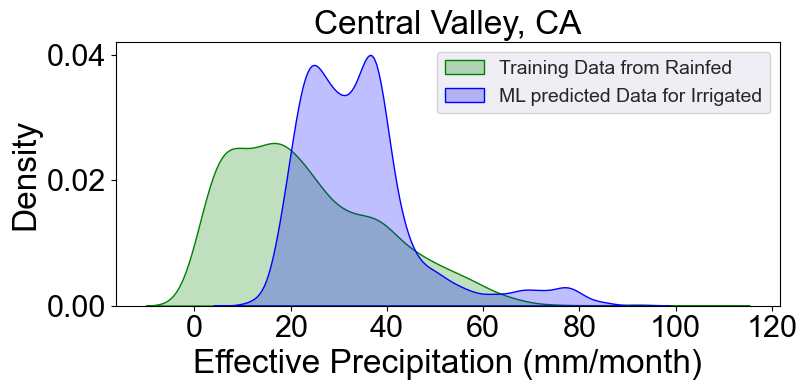

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_style("darkgrid")
fig.set_facecolor('none')

sns.kdeplot(cv_train_df.cv_train, ax=ax, fill=True, color="g", label='Training Data from Rainfed')
sns.kdeplot(cv_pred_df.cv_pred, ax=ax, fill=True, color="b", label='ML predicted Data for Irrigated')
ax.set_xlabel('Effective Precipitation (mm/month)', fontsize=24)
ax.set_ylabel('Density', fontsize=24)
ax.tick_params(axis='both', labelsize=22)
ax.set_title('Central Valley, CA', fontsize=24)
ax.legend(prop = { "size": 14})
plt.tight_layout()

figname = 'Eff_precip_prediction_performance_CV.png'
fig.savefig(os.path.join(plot_output_dir, figname), dpi=150)

## Snake River, ID

In [9]:
sr_train_arr, _ = mask_raster_by_extent(input_raster=training_raster, ref_file=sr_training_zone, 
                                     output_dir=data_output_dir, raster_name='sr_training.tif', 
                                     invert=False, crop=True, nodata=-9999)

sr_pred_arr, _ = mask_raster_by_extent(input_raster=prediction_raster, ref_file=sr_training_zone, 
                                    output_dir=data_output_dir, raster_name='sr_prediction.tif', 
                                    invert=False, crop=True, nodata=-9999)

C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [10]:
sr_train_df = pd.DataFrame({'sr_train': sr_train_arr.flatten()})
sr_train_df = sr_train_df[(sr_train_df.sr_train != -9999)]
sr_train_df = sr_train_df.dropna().reset_index(drop=True)
# sr_train_df.head()

In [11]:
sr_pred_df = pd.DataFrame({'sr_pred': sr_pred_arr.flatten()})
sr_pred_df = sr_pred_df[sr_pred_df.sr_pred != -9999]
sr_pred_df = sr_pred_df.dropna().reset_index(drop=True)
# sr_pred_df.head()

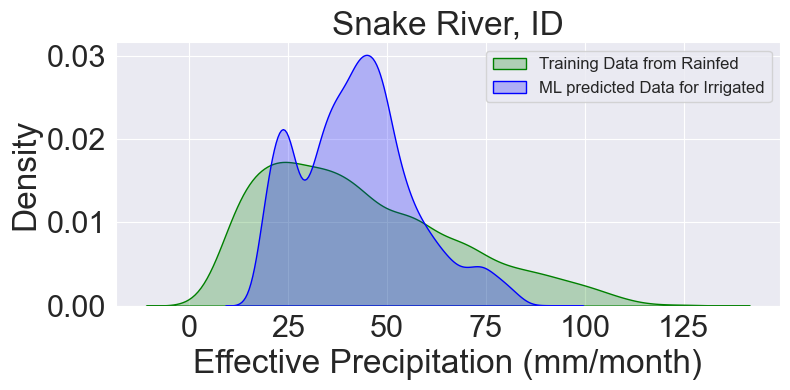

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_style("darkgrid")
fig.set_facecolor('none')

sns.kdeplot(sr_train_df.sr_train, ax=ax, fill=True, color="g", label='Training Data from Rainfed')
sns.kdeplot(sr_pred_df.sr_pred, ax=ax, fill=True, color="b", label='ML predicted Data for Irrigated')
ax.set_xlabel('Effective Precipitation (mm/month)', fontsize=24)
ax.set_ylabel('Density', fontsize=24)
ax.tick_params(axis='both', labelsize=22)
ax.set_title('Snake River, ID', fontsize=24)
ax.legend(prop = { "size": 12})
plt.tight_layout()

figname = 'Eff_precip_prediction_performance_SR.png'
fig.savefig(os.path.join(plot_output_dir, figname), dpi=150)

## HPA, KS

In [13]:
gmd_train_arr, _ = mask_raster_by_extent(input_raster=training_raster, ref_file=gmd_training_zone, 
                                     output_dir=data_output_dir, raster_name='gmd_training.tif', 
                                     invert=False, crop=True, nodata=-9999)

gmd_pred_arr, _ = mask_raster_by_extent(input_raster=prediction_raster, ref_file=gmd_training_zone, 
                                    output_dir=data_output_dir, raster_name='gmd_prediction.tif', 
                                    invert=False, crop=True, nodata=-9999)

C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [14]:
gmd_train_df = pd.DataFrame({'gmd_train': gmd_train_arr.flatten()})
gmd_train_df = gmd_train_df[(gmd_train_df.gmd_train != -9999)]
gmd_train_df = gmd_train_df.dropna().reset_index(drop=True)
# gmd_train_df.head()

In [15]:
gmd_pred_df = pd.DataFrame({'gmd_pred': gmd_pred_arr.flatten()})
gmd_pred_df = gmd_pred_df[gmd_pred_df.gmd_pred != -9999]
gmd_pred_df = gmd_pred_df.dropna().reset_index(drop=True)
# gmd_pred_df.head()

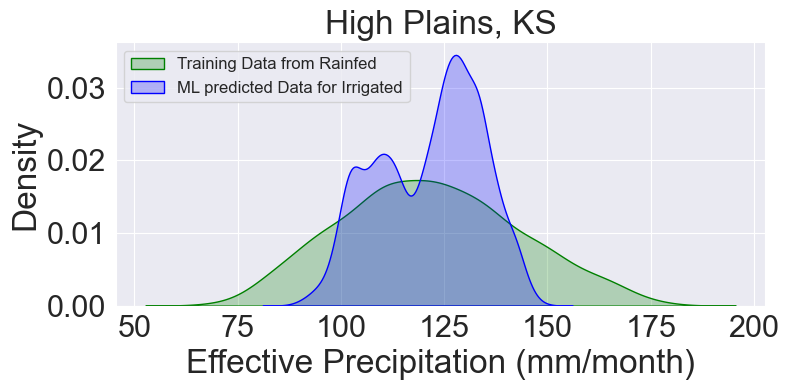

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_style("darkgrid")
fig.set_facecolor('none')

sns.kdeplot(gmd_train_df.gmd_train, ax=ax, fill=True, color="g", label='Training Data from Rainfed')
sns.kdeplot(gmd_pred_df.gmd_pred, ax=ax, fill=True, color="b", label='ML predicted Data for Irrigated')
ax.set_xlabel('Effective Precipitation (mm/month)', fontsize=24)
ax.set_ylabel('Density', fontsize=24)
ax.tick_params(axis='both', labelsize=22)
ax.set_title('High Plains, KS', fontsize=24)
ax.legend(loc='upper left', prop = { "size": 12})
plt.tight_layout()

figname = 'Eff_precip_prediction_performance_GMD.png'
fig.savefig(os.path.join(plot_output_dir, figname), dpi=150)

## HPA, NE

In [17]:
NE_train_arr, _ = mask_raster_by_extent(input_raster=training_raster, ref_file=ne_training_zone, 
                                     output_dir=data_output_dir, raster_name='ne_training.tif', 
                                     invert=False, crop=True, nodata=-9999)

NE_pred_arr, _ = mask_raster_by_extent(input_raster=prediction_raster, ref_file=ne_training_zone, 
                                    output_dir=data_output_dir, raster_name='ne_prediction.tif', 
                                    invert=False, crop=True, nodata=-9999)

C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\fahim\Anaconda3\envs\WestUS_netGW\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
NE_train_df = pd.DataFrame({'NE_train': NE_train_arr.flatten()})
NE_train_df = NE_train_df[(NE_train_df.NE_train != -9999)]
NE_train_df = NE_train_df.dropna().reset_index(drop=True)
# NE_train_df.head()

In [19]:
NE_pred_df = pd.DataFrame({'NE_pred': NE_pred_arr.flatten()})
NE_pred_df = NE_pred_df[NE_pred_df.NE_pred != -9999]
NE_pred_df = NE_pred_df.dropna().reset_index(drop=True)
# NE_pred_df.head()

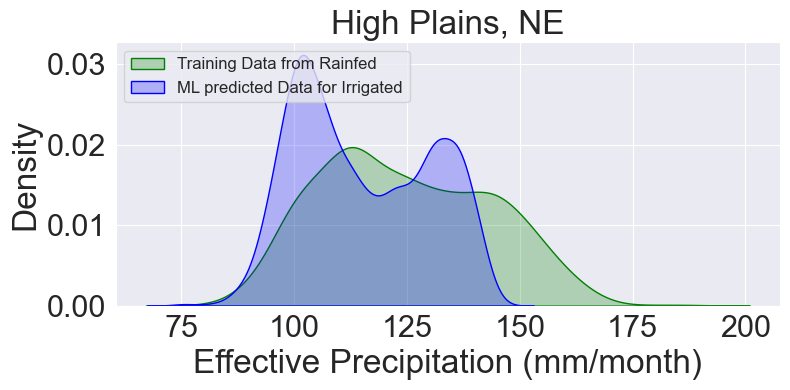

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_style("darkgrid")
fig.set_facecolor('none')

sns.kdeplot(NE_train_df.NE_train, ax=ax, fill=True, color="g", label='Training Data from Rainfed')
sns.kdeplot(NE_pred_df.NE_pred, ax=ax, fill=True, color="b", label='ML predicted Data for Irrigated')
ax.set_xlabel('Effective Precipitation (mm/month)', fontsize=24)
ax.set_ylabel('Density', fontsize=24)
ax.tick_params(axis='both', labelsize=22)
ax.set_title('High Plains, NE', fontsize=24)
ax.legend(loc='upper left', prop = { "size": 12})
plt.tight_layout()

figname = 'Eff_precip_prediction_performance_NE.png'
fig.savefig(os.path.join(plot_output_dir, figname), dpi=150)